## Exploration

In [30]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from lightgbm import LGBMClassifier


train.csv shape is  (139753, 9)
test.csv shape is  (17470, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   195370  1890228583  A3VLX5Z090RQ0V                     1   
1  1632470  B00BEIYSL4   AUDXDMFM49NGY                     0   
2     9771  0767809335  A3LFIA97BUU5IE                     3   
3   218855  6300215792  A1QZM75342ZQVQ                     1   
4   936225  B000B5XOZW   ANM2SCEUL3WL1                     1   

   HelpfulnessDenominator        Time  \
0                       2  1030838400   
1                       1  1405036800   
2                      36   983750400   
3                       1  1394841600   
4                       1  1163721600   

                                             Summary  \
0                        An Unexplained Anime Review   
1                                         not great.   
2                    Technical problem with this DVD   
3                          Heeeeyyyyy LAAAAADEEE!!!!   
4  Herzog the Great Trave

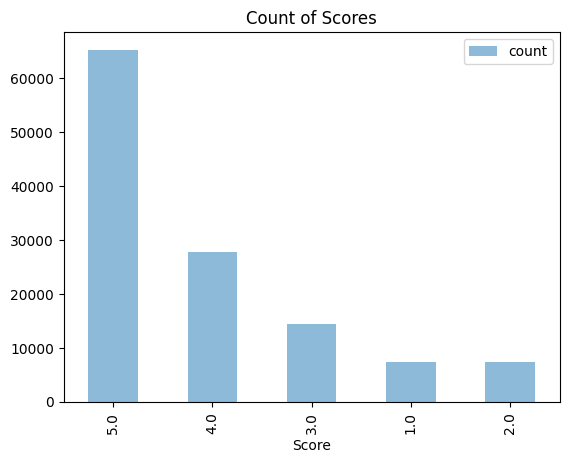

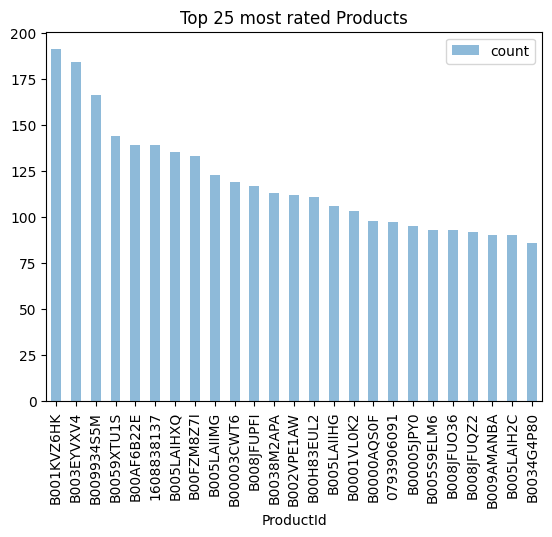

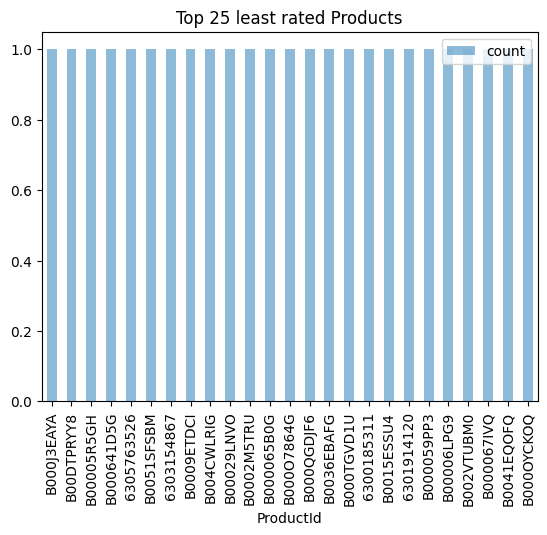

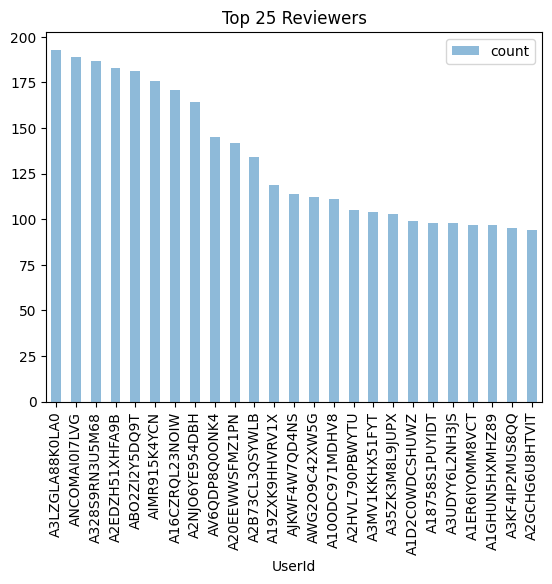

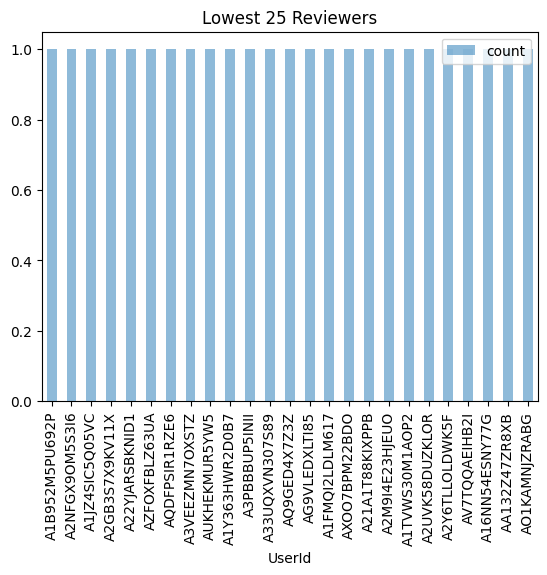

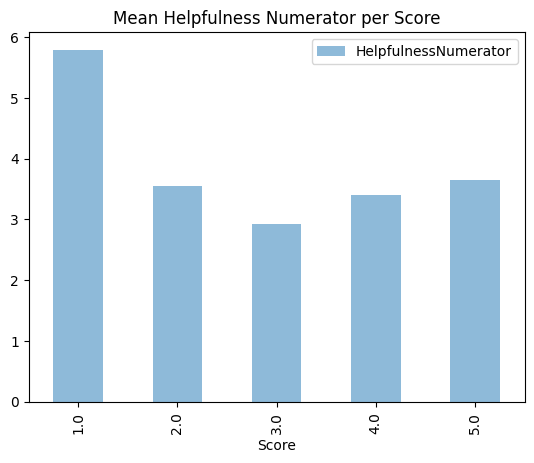

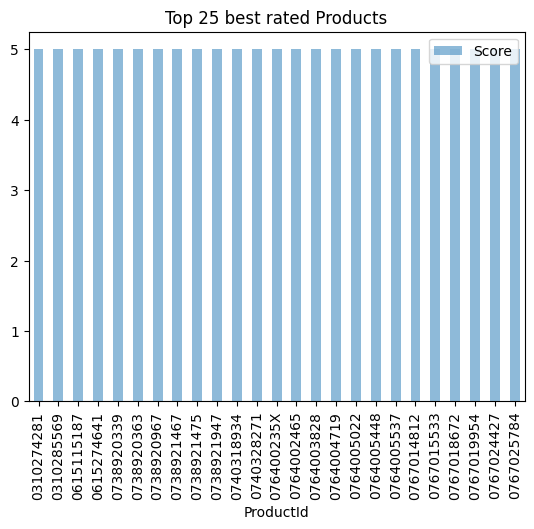

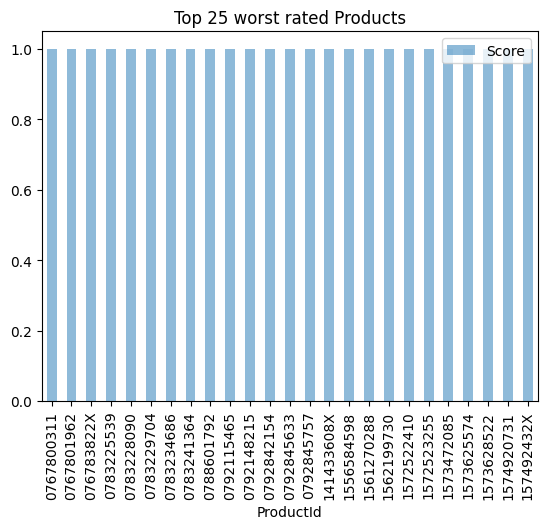

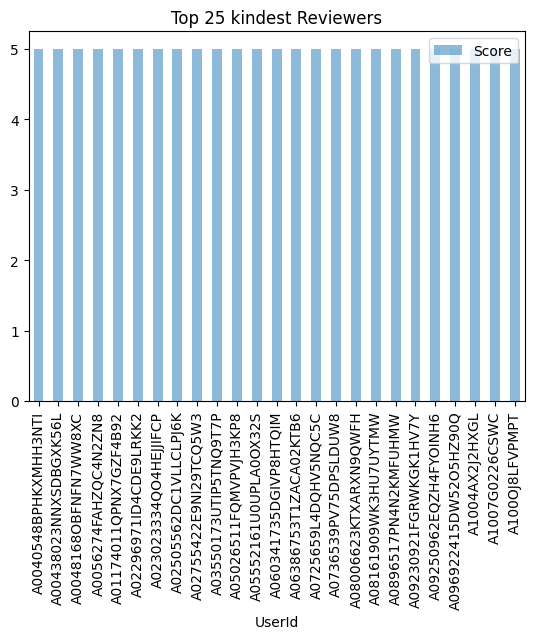

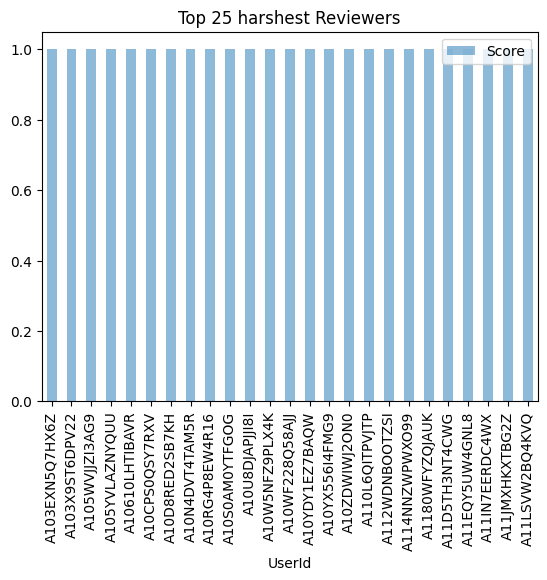

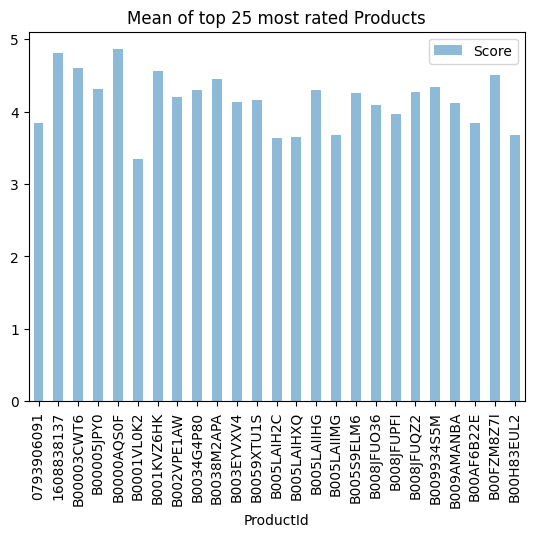

In [2]:

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

## Feature Extraction

In [3]:

import re
import os
import sys
import json

import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob
import swifter
from sklearn.feature_extraction.text import CountVectorizer


def _get_wordcounts(x):
 length = len(str(x).split())
 return length

def _get_charcounts(x):
 s = x.split()
 x = ''.join(s)
 return len(x)

def _get_avg_wordlength(x):
 wordCount = _get_wordcounts(x)
 charCount = _get_charcounts(x)
 if wordCount == 0 or charCount == 0:
  return 0
 else:
    count = _get_charcounts(x)/_get_wordcounts(x)
    return count

def _get_stopwords_counts(x):
 l = len([t for t in x.split() if t in stopwords])
 return l

def _get_hashtag_counts(x):
 l = len([t for t in x.split() if t.startswith('#')])
 return l

def _get_mentions_counts(x):
 l = len([t for t in x.split() if t.startswith('@')])
 return l

def _get_digit_counts(x):
 digits = re.findall(r'[0-9,.]+', x)
 return len(digits)

def _get_uppercase_counts(x):
 return len([t for t in x.split() if t.isupper()])


def get_emails(x):
 emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
 counts = len(emails)

 return counts, emails


def remove_emails(x):
 return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def get_urls(x):
 urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
 counts = len(urls)

 return counts, urls

def remove_urls(x):
 return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_rt(x):
 return re.sub(r'\brt\b', '', x).strip()

def remove_special_chars(x):
 x = re.sub(r'[^\w ]+', "", x)
 x = ' '.join(x.split())
 return x

def remove_html_tags(x):
 return BeautifulSoup(x, 'lxml').get_text().strip()

def remove_accented_chars(x):
 x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
 return x

def remove_stopwords(x):
 return ' '.join([t for t in x.split() if t not in stopwords])

def get_value_counts(df, col):
 text = ' '.join(df[col])
 text = text.split()
 freq = pd.Series(text).value_counts()
 return freq

def remove_common_words(x, freq, n=20):
 fn = freq[:n]
 x = ' '.join([t for t in x.split() if t not in fn])
 return x

def remove_rarewords(x, freq, n=20):
 fn = freq.tail(n)
 x = ' '.join([t for t in x.split() if t not in fn])
 return x

def remove_dups_char(x):
 x = re.sub("(.)\\1{2,}", "\\1", x)
 return x

def spelling_correction(x):
 x = TextBlob(x).correct()
 return x
def _get_sentiment(x):
    analysis = TextBlob(x)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def get_basic_features(df):
    df['Text'] = df['Text'].fillna('') 
    df['char_counts'] = df['Text'].apply(lambda x: _get_charcounts(x))
    df['word_counts'] = df['Text'].apply(lambda x: _get_wordcounts(x))
    df['avg_wordlength'] = df['Text'].apply(lambda x: _get_avg_wordlength(x))
    df['stopwords_counts'] = df['Text'].apply(lambda x: _get_stopwords_counts(x))
    df['hashtag_counts'] = df['Text'].apply(lambda x: _get_hashtag_counts(x))
    df['mentions_counts'] = df['Text'].apply(lambda x: _get_mentions_counts(x))
    df['digits_counts'] = df['Text'].apply(lambda x: _get_digit_counts(x))
    df['uppercase_counts'] = df['Text'].apply(lambda x: _get_uppercase_counts(x))
    df['Helpfulness'] = df.apply(lambda x: x['HelpfulnessNumerator'] / (x['HelpfulnessDenominator'] if x['HelpfulnessDenominator'] > 0 else np.nan), axis=1)
    df['Helpfulness'].fillna(0, inplace=True)
    df['SentimentPolarity'] = df['Text'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['SentimentSubjectivity'] = df['Text'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df['SentimentPolaritySummary'] = df['Summary'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['SentimentSubjectivitySummary'] = df['Summary'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df['SentimentPolaritySubjectivitySummary'] = df['Summary'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df
    
trainingSet = pd.read_csv("./data/train.csv")
train_processed = get_basic_features(trainingSet)
submissionSet = pd.read_csv("./data/test.csv")
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})
trainX =  train_processed[train_processed['Score'].notnull()]
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply: 100%|██████████| 139753/139753 [00:15<00:00, 8758.76it/s] 


IGNORE

In [13]:
X_train = pd.read_csv("./data/X_train.csv")
X_train['Score'] = X_train['Score'] - 1

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(['Score'], axis=1),
    X_train['Score'],
    test_size=0.25,
    random_state=42
)
X_train['Text'].fillna('', inplace=True)
X_test['Text'].fillna('', inplace=True)
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Summary','Time', 'Text',
       'char_counts', 'word_counts', 'avg_wordlength', 'stopwords_counts',
       'hashtag_counts', 'mentions_counts', 'digits_counts',
       'uppercase_counts'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Summary','Time', 'Text',
       'char_counts', 'word_counts', 'avg_wordlength', 'stopwords_counts',
       'hashtag_counts', 'mentions_counts', 'digits_counts',
       'uppercase_counts'])

X_train_processed.columns

In [27]:
X_train = pd.read_csv("./data/X_train.csv")
X_train['Score'] = X_train['Score'] - 1

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(['Score'], axis=1),
    X_train['Score'],
    test_size=0.25,
    random_state=42
)
X_train['Text'].fillna('', inplace=True)
X_test['Text'].fillna('', inplace=True)
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Summary','Time',
       'char_counts', 'word_counts', 'avg_wordlength', 'stopwords_counts',
       'hashtag_counts', 'mentions_counts', 'digits_counts',
       'uppercase_counts'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Summary','Time',
       'char_counts', 'word_counts', 'avg_wordlength', 'stopwords_counts',
       'hashtag_counts', 'mentions_counts', 'digits_counts',
       'uppercase_counts'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weight_dict = dict(enumerate(class_weights))


estimators = [
    ('lgb', LGBMClassifier(
        objective='multiclass',
        num_class=len(Y_train.unique()),
        n_estimators=100,
        learning_rate=0.05,
        class_weight=class_weight_dict)),
    ('svr', LinearSVR())
]

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('txt', text_transformer, 'Text')

    ],
    remainder='passthrough' 
)
final_estimator = LogisticRegression()
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])



pipeline.fit(X_train_processed, Y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.166327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147384
[LightGBM] [Info] Number of data points in the train set: 91712, number of used features: 20552
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979698
[LightGBM] [Info] Number of data points in the train set: 73369, number of used features: 18292
[LightGBM] [Info] Start training from score -1.609473
[LightGBM] [Info] Start training from score -1.609381
[LightGBM] [Info] Start training from score -1.609450
[LightGBM] [Info] Start training from score -1.609463
[LightGBM] [Info] Start training from score -1.609422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.083872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981302
[LightGBM] [Info] Number of data points in the train set: 73369, number of used features: 18323
[LightGBM] [In

c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mitia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('txt',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'Text')])),
                ('classifier',
                 StackingClassifier(estimators=[('lgb',
                                                 LGBMClassifier(class_weight={0: 3.3508220679576177,
                                                                              1: 3.355726308086352,
                                                                              2: 1.690699603650106,
                                                                              3: 0.8739886596464478,
                                                                              4: 0.37482426025829657},
                                                                learning_rate=0.05,
                                                                n_estimators=1000,
                                                                num_class=5,
                                                                objective='multiclass')),
                                                ('svr', LinearSVR())],
                                    final_estimator=LogisticRegression()))])

## Creating your model

Accuracy on testing set =  0.6489483497432207
Accuracy on testing set =  0.6489483497432207
RMSE on testing set =  0.8530626056158642


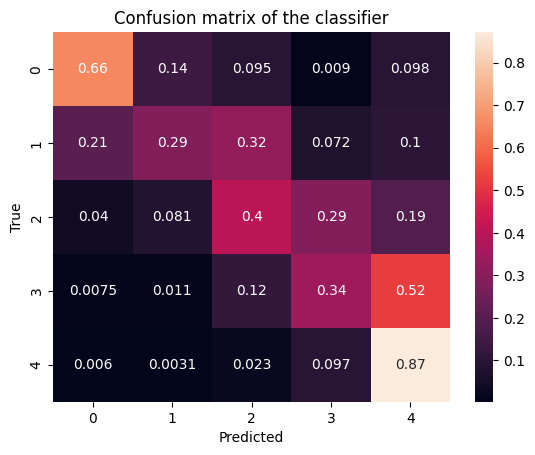

In [28]:

Y_test_predictions = pipeline.predict(X_test_processed)

accuracy_test = accuracy_score(Y_test, Y_test_predictions)
print("Accuracy on testing set = ", accuracy_test)

accuracy_test = accuracy_score(Y_test, Y_test_predictions)
rmse_test = mean_squared_error(Y_test, Y_test_predictions, squared=False)
print("Accuracy on testing set = ", accuracy_test)
print("RMSE on testing set = ", rmse_test)

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Create the Kaggle submission

In [29]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Summary'])

X_submission['Score'] = pipeline.predict(X_submission_processed)
X_submission['Score'] = X_submission['Score'] + 1
submission = X_submission[['Id', 'Score']]
print(submission.head())

submission.to_csv("./data/submission.csv", index=False)


        Id  Score
0   786781    3.0
1    17153    5.0
2  1557328    3.0
3  1242666    5.0
4  1359242    5.0


Now you can upload the `submission.csv` to kaggle